## Training mixed-VAE

Let us use datasets prostate cancer and veteran datasets from r-package Asaur in this tutorial. In addition to fitting models, we store them for later use and create multiple synthetic data sets for each datasets. In an another tutorial we take a closer look at the quality of the synthetic data by trying to replicate results from the Applied survival analysis book.

[Prostate cancer](#Prostate-cancer)

[Veteran](#Veteran-dataset)



# Prostate cancer

Prostate cancer dataset contains variables grade, stage, ageGroup, survTime and status.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

#Change working directory
os.chdir('..')

from data_processing import *

#Load data and print the first rows
X = pd.read_csv('Data/prostateSurvival.csv')
data_dict = data_dictionary(X)

X.head()

,grade,stage,ageGroup,survTime,status
0,mode,T1c,80+,18,0
1,mode,T1ab,75-79,23,0
2,poor,T1c,75-79,37,0
3,mode,T2,70-74,27,0
4,mode,T1c,70-74,42,0


We have to define a probability distribution for each variable. Below are the possible distributions. Tensorflow-probability library is used in this implementation. Next to distribution name is the code for the distribution.

* Categorical variables 
   * Categorical distribution : "cat"

* Integer variables
  * Poisson : "int_Poisson"
  * Negative binomial : "int_negBin"  

* Real variables
  * Normal : "real_Normal"
  * Laplace : "real_Laplace"
  * Gamma : "real_Gamma"
  

Variable survTime is only non-categorical variable in the dataset. Lets take a look of it before any modelling choices. 

<AxesSubplot:xlabel='survTime', ylabel='Density'>

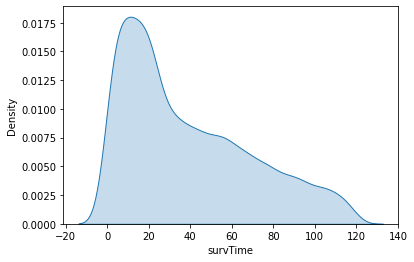

In [2]:
sns.kdeplot(data=X,x="survTime",shade=True,palette="deep", common_norm=False)

We could try to model it with negative binomial distribution. We have to feed selected distributions to the preprocessing function in a list.

In [2]:
variable_types = ["cat", "cat", "cat", "int_negBin", "cat"]
X_input, X_dict, realisation_counts, = get_inputs_outputs(X, data_dict, variable_types)
decoder_int_output_size = decoder_int_output_layer_size(variable_types)


Hyperparameter selection are:

* z_dim: 
  * Size of z when z = Encoder(x)
* batch_size:
  * Number of data points in one parameter update
* optimizer_learning_rate: 
  * learning rate for optimization algorithm
* epochs/batches: 
  * Number of times each data point are used

In [3]:
#Import the model and a function for the training loop
from vaeMixed import VAE_mixed
from training import training_loop

#Model hyperparameters
z_dim = 3
encoder_size = 40
decoder_size = 40

#Create model
model = VAE_mixed(X, X_dict, z_dim, encoder_size, decoder_size, realisation_counts, variable_types, decoder_int_output_size)

#Training parameters
epochs = 1
batch_size = 100
optimizer_learning_rate = 0.05

#Use training_loop function to update model parameters
model, losses = training_loop(model, X, epochs, batch_size, optimizer_learning_rate, X_input, X_dict)

#Print model summary
model.summary()

0
Model: "vae_mixed"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  560       
_________________________________________________________________
dense_1 (Dense)              multiple                  123       
_________________________________________________________________
dense_2 (Dense)              multiple                  123       
_________________________________________________________________
dense_3 (Dense)              multiple                  160       
_________________________________________________________________
dense_4 (Dense)              multiple                  492       
_________________________________________________________________
dense_5 (Dense)              multiple                  82        
Total params: 1,540
Trainable params: 1,540
Non-trainable params: 0
_____________________________________________________

Let's visualize marginal distributions of original and synthetic data.

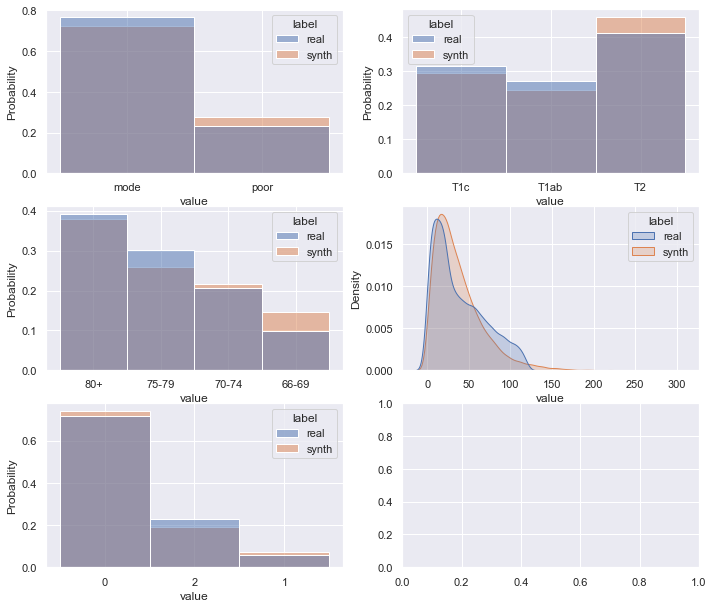

In [4]:
from data_visualization import plot_marginal_marginal_distr_for_realValued_variables, plot_histogram

#Helper variables for plotting multiple distributions
sns.set(rc={'figure.figsize':(11.7,10.27)})
fig, ax = plt.subplots(3,2)
a = [0,0,1,1,2,2]
b = [0,1,0,1,0,1]


#Siirrä nämä data processing tiedostoon? Lisää myös muuttujanimet otsikkona
for i in range(len(variable_types)):
    if variable_types[i] == 'cat':
        x_plot = plot_histogram(X_dict, model, model.columns[i], data_dict, numeric = False)
        sns.histplot(data=x_plot,x="value",hue="label",palette="deep", stat = 'probability', common_norm=False, ax=ax[a[i],b[i]])
    else:
        x_plot = plot_marginal_marginal_distr_for_realValued_variables(X_dict, model.columns[i], model) 
        sns.kdeplot(data=x_plot,x="value",hue="label",shade=True,palette="deep", common_norm=False, ax=ax[a[i],b[i]])


Since marginal distributions look nice and we are happy with the model we can save it. Let's also test whether we can read the saved model and print its summary.

In [5]:
# Save the weights
model.save('Models/Prostate_cancer/prostate_cancer_model')

# Create a new model instance
new_model = tf.keras.models.load_model('Models/Prostate_cancer/prostate_cancer_model')

# Check its architecture
new_model.summary()

INFO:tensorflow:Assets written to: Models/Prostate_cancer/prostate_cancer_model\assets
Model: "vae_mixed"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  560       
_________________________________________________________________
dense_1 (Dense)              multiple                  123       
_________________________________________________________________
dense_2 (Dense)              multiple                  123       
_________________________________________________________________
dense_3 (Dense)              multiple                  160       
_________________________________________________________________
dense_4 (Dense)              multiple                  492       
_________________________________________________________________
dense_5 (Dense)              multiple                  82        
Total params: 1,540
Trainable params

# Veteran dataset



In [6]:
#Load data and print the first rows
X = pd.read_csv('Data/veteran.csv')
data_dict = data_dictionary(X)

X.head()

,trt,celltype,time,status,karno,diagtime,age,prior
0,1,squamous,72,1,60,7,69,0
1,1,squamous,411,1,70,5,64,10
2,1,squamous,228,1,60,3,38,0
3,1,squamous,126,1,60,9,63,10
4,1,squamous,118,1,70,11,65,10


Let us again fit the model. We really should do some hyperparameter tuning, but I save that for later notebooks. We could for example set the loss function in such way, that it punishes if synthetic data marginal distributions differ from original data marginal distributions. Also distances between correlations matrices could be used or perhaps compinations of these two.

Next chunk also calculates and plots combined bhattacharyya-distance during training [https://en.wikipedia.org/wiki/Bhattacharyya_distance].

C:\Users\visam\OneDrive\Documents\Mixed_vae\Bhattacharyya_distance.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == "":


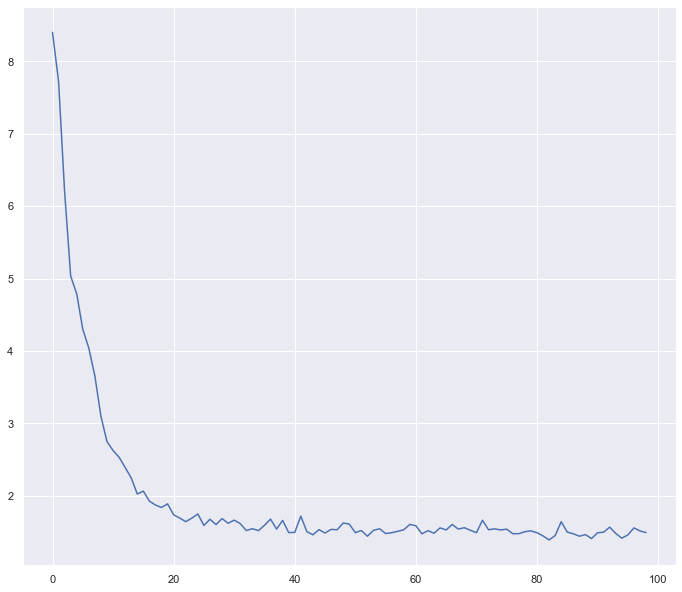

In [7]:
from training import training_loop_no_epochs_B_loss 

#"O" means variable is modelled by categorical distribution. Anything else is negative binomial distribution
variable_types = ["cat", "cat", "int_negBin", "cat", "int_negBin", "int_negBin","int_negBin","cat"]

data_dict = data_dictionary(X)

X_input, X_dict, realisation_counts, = get_inputs_outputs(X, data_dict, variable_types)

decoder_int_output_size = decoder_int_output_layer_size(variable_types)

z_dim = 3
model = VAE_mixed( X, X_dict, z_dim, 40, 40, realisation_counts, variable_types, decoder_int_output_size)

batch_size = 30
optimizer_learning_rate = 0.05
batches = 1000 
model, losses, b_loss = training_loop_no_epochs_B_loss(model, X, batches, batch_size, optimizer_learning_rate, X_input, X_dict, variable_types, M_samples = 10)
plt.plot(b_loss)

Let us again plot marginal distributions for synthetic and original data.

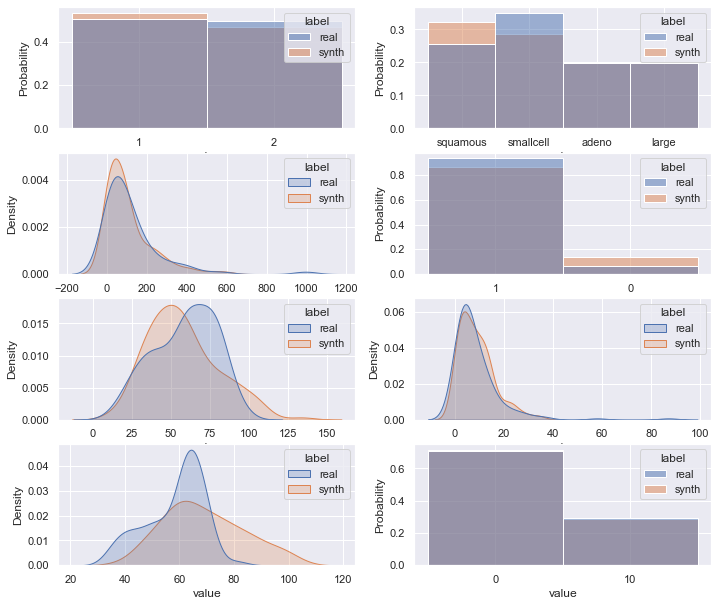

In [9]:
#Helper variables for plotting multiple distributions
fig, ax = plt.subplots(4,2)
a = [0,0,1,1,2,2,3,3]
b = [0,1,0,1,0,1,0,1]

#Siirrä nämä data processing tiedostoon? Lisää myös muuttujanimet otsikkona
for i in range(len(variable_types)):
    if variable_types[i] == 'cat':
        x_plot = plot_histogram(X_dict, model, model.columns[i], data_dict, numeric = False)
        sns.histplot(data=x_plot,x="value",hue="label",palette="deep", stat = 'probability', common_norm=False, ax=ax[a[i],b[i]])
    else:
        x_plot = plot_marginal_marginal_distr_for_realValued_variables(X_dict, model.columns[i], model) 
        sns.kdeplot(data=x_plot,x="value",hue="label",shade=True,palette="deep", common_norm=False, ax=ax[a[i],b[i]])


One can see, that data quality is not perfect. Careful hyperparameter tuning might be the solution. Also normalising and transforming the data might be wise. For example we could do log-transformation for fat-tailed distributions and model the transformation using normal or laplace distribution.